In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.tri as tri
from scipy.stats import pearsonr, spearmanr
from scipy.spatial import KDTree
import fipy as fp
import h5py

In [3]:
path='/home/artem.kays/scripts/lncRNAeffects/RNA_diffusion'
os.chdir(path)
from utils.input_parse import *
from utils.utils import *
from utils.graphics_3d import *
from utils.graphics import *
from utils.free_energy import *

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['font.size']=16

### Initialization

Variables with '_dense' suffix should be specified with separate initialization run to produce double plots below

In [43]:
input_parameters = input_parse('input/input_params_sparse.txt') #_diffusion _sparse
dim = input_parameters['dimension']
sparse = input_parameters['sparse']
chrom_f = input_parameters['chrom_f']
chrom_size = input_parameters['chrom_size']
space_scale=input_parameters['space_scale']
min_size = input_parameters['min_size']
scale = input_parameters['scale']
sigma_chr = input_parameters['sigma_chr']

In [170]:
sample = ['GSM5851256_MCF7_Rep1_bin_50Kb_chr11_60Mb_70Mb',
           'GSM5851256_MCF7_Rep1_bin_50Kb_chr11_60Mb_70Mb_sparse']
sample = sample[1]
# sim_ = ['n_cells_2500.0_sigma_chr_0.5_c_DH_0.1_sigma_DH_10.0_k_p_max_lncRNA_25.0',
#         'n_cells_2500.0_sigma_chr_0.5_c_DH_0.05_sigma_DH_10.0_k_p_max_lncRNA_2.5',
#         'n_cells_2500.0_sigma_chr_0.5_c_DH_0.02_sigma_DH_10.0_k_p_max_lncRNA_2.5',
#         'n_cells_2500.0_sigma_chr_0.5_c_DH_0.01_sigma_DH_10.0_k_p_max_lncRNA_25.0',
#         'n_cells_2500.0_sigma_chr_0.5_c_RNAchr_0.02_sigma_RNAchr_0.5_k_p_max_lncRNA_25.0',
#         'n_cells_2500.0_sigma_chr_0.5_c_RNAchr_0.2_sigma_RNAchr_0.5_k_p_max_lncRNA_25.0']

sim_ = ['n_cells_2500.0_sigma_chr_0.5_c_RNAchr_0.2_sigma_RNAchr_0.5_k_p_max_lncRNA_25.0',
        'n_cells_2500.0_sigma_chr_0.5_c_RNAchr_0.2_sigma_RNAchr_0.5_k_p_max_lncRNA_2.5',
        'n_cells_2500.0_sigma_chr_0.5_c_RNAchr_0.02_sigma_RNAchr_0.5_k_p_max_lncRNA_25.0',
        'n_cells_2500.0_sigma_chr_0.5_c_RNAchr_0.02_sigma_RNAchr_0.5_k_p_max_lncRNA_2.5']
outd = '20250315'
mesh_f = f'results/{sample}/mesh_min_size_0.1_scale_5.0_sigma_chr_0.5.msh2'
dist_f = f'results/{sample}/dist_min_size_0.1_scale_5.0_sigma_chr_0.5.hdf5'
sim = sim_[3]

if not os.path.exists(f'{path}/figures/{sample}'):
    os.makedirs(f'{path}/figures/{sample}')

if not os.path.exists(f'{path}/figures/{sample}/{sim}'):
        os.makedirs(f'{path}/figures/{sample}/{sim}')

In [19]:
bin_r, bin_r_spline = parse_chrom(chrom_f, chrom_size)
# bin_r_spline = lin_interp(bin_r, 10)

In [20]:
mesh = fp.Gmsh3D(mesh_f)
if not sparse:
    mesh_dense = mesh
mesh.cellCenters.shape

(3, 78523)

In [21]:
with h5py.File(dist_f, 'r') as f:
    d_chr = f['d_chr'][:]
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = d_chr)
if not sparse:
    d_chr_dense = d_chr

if not sparse:
    d_chr_sur = fp.CellVariable(mesh=mesh, name=r'$d_{chr\_sur}$', value = d_chr - input_parameters['sigma_chr'])
else:
    d_chr_sur = d_chr

In [10]:
p_o = lambda x, i=input_parameters: x + "_" + str(i[x]) + "_"
out_params = ['n_cells', 'sigma_chr', 'c_RNAchr', 'sigma_RNAchr', 'k_p_max_lncRNA'] # Modify to add parametes to the output dir name
output_dir = (input_parameters['output_dir'] + 'GSM5851256_MCF7_Rep1_bin_50Kb_chr11_60Mb_70Mb' + '/' +
              '_'.join(f'{x}_{str(input_parameters[x])}' for x in out_params))

val_lim = {}
for spvar in ["phi_p", "phi_r", "phi_m", "mu_p", "mu_r", "mu_m", "free_energy"]:
    val_lim[spvar] = (input_parameters[f'{spvar}_min_plot'], input_parameters[f'{spvar}_max_plot'])

In [22]:
rna_nucleus_location = bin_r[int(input_parameters['lncRNA_gene_bin'])]
plane_pos=(rna_nucleus_location[2] - mesh.z.value.min()) / (mesh.z.value.max() - mesh.z.value.min())
list_of_variables = ["phi_p", "phi_r", "mu_p", "mu_r", "free_energy"]
# write_movie_from_hdf5(output_dir, list_of_variables, dim, mesh, fps=2, val_lim=val_lim, bin_r=bin_r_spline,
#                       plane_pos=plane_pos, thres=min_size/2, d_chr=d_chr.value, sigma_chr=sigma_chr)

In [23]:
thres = min_size / 2
plane = mesh.z.value.min() + plane_pos * (mesh.z.value.max() - mesh.z.value.min())
mask_z = (abs(mesh.z.value - plane) < thres * (1 + 10*(d_chr/d_chr.max())**2))
triang = mesh_triang(mesh, sparse, mask_z, bin_r_spline, sigma_chr, mode_cells=1)
if not sparse:
    mask_z_dense = mask_z
    triang_dense = triang

In [24]:
FE = free_energy_RNA_Chrom_FH(
                 NP=input_parameters['NP'], 
                 NR=input_parameters['NR'],
                 chi_p=input_parameters['chi_p'],
                 chi_pr=input_parameters['chi_pr'], 
                 chi_r=input_parameters['chi_r'],
                 c_RNAchr = input_parameters['c_RNAchr'],
                 sigma_RNAchr = input_parameters['sigma_RNAchr'],
                 wall_k = input_parameters['wall_k'],
                 neg_max = input_parameters['neg_max'])

if not sparse:
    specific_RNAchr_dense = FE.specific_DH(mesh_dense, d_chr)
else:
    specific_RNAchr = FE.specific_RNAchr(mesh, d_chr)

### Concentration-independent plots

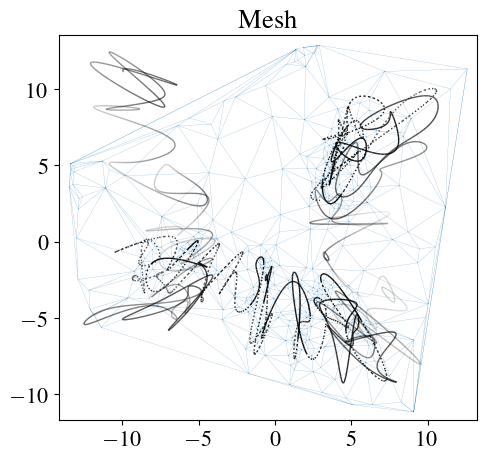

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax.triplot(triang, lw=0.1)
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)

ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)
ax.set_aspect('equal', adjustable='box')
plt.title(f'Mesh')
fig.savefig(fname=f'{path}/figures/{outd}/mesh.png', bbox_inches='tight', dpi=300, format='png')

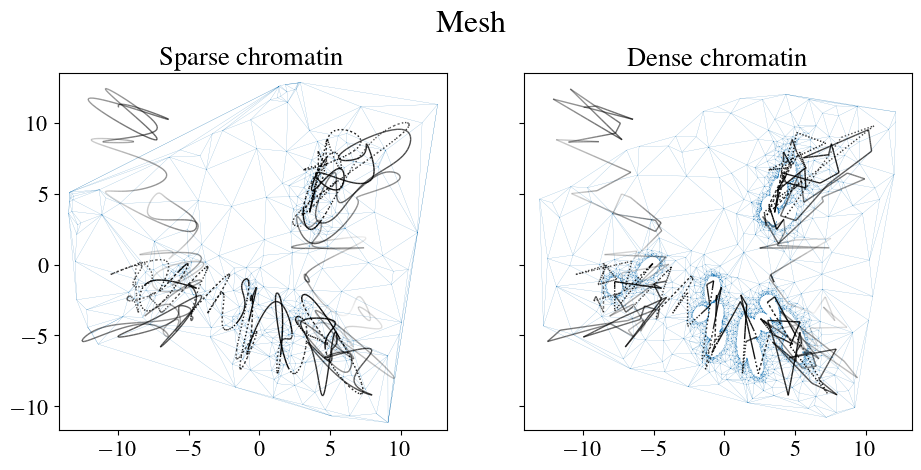

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)

axes[0].triplot(triang, lw=0.1)
axes[1].triplot(triang_dense, lw=0.1)
plot_curve_with_opacity(axes[0], bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)
plot_curve_with_opacity(axes[1], bin_r, z_plane=plane, num_segments=10, global_max=0, visibility=1)

for ax in axes:
    ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
    ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.set_aspect('equal', adjustable='box')
axes[0].set_title(f'Sparse chromatin')
axes[1].set_title(f'Dense chromatin')
plt.suptitle(f'Mesh', size='x-large')

fig.savefig(fname=f'{path}/figures/{outd}/mesh.png', bbox_inches='tight', dpi=300, format='png')

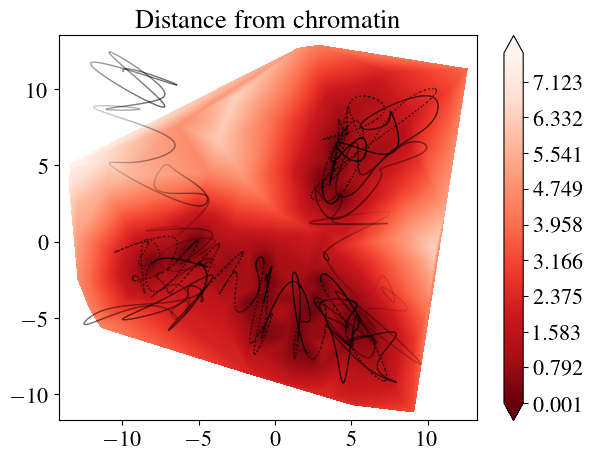

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
# plt.title(f'{name} equilibrium distribution')
cs = ax.tricontourf(triang,
                    d_chr[mask_z],
                    levels=np.linspace(d_chr.min(), d_chr.max(), 256),
                    cmap="Reds_r",
                    extend="both")
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)
cbar=fig.colorbar(cs, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)
plt.title(f'Distance from chromatin')
fig.savefig(fname=f'{path}/figures/{outd}/d_chr.png', bbox_inches='tight', dpi=300, format='png')

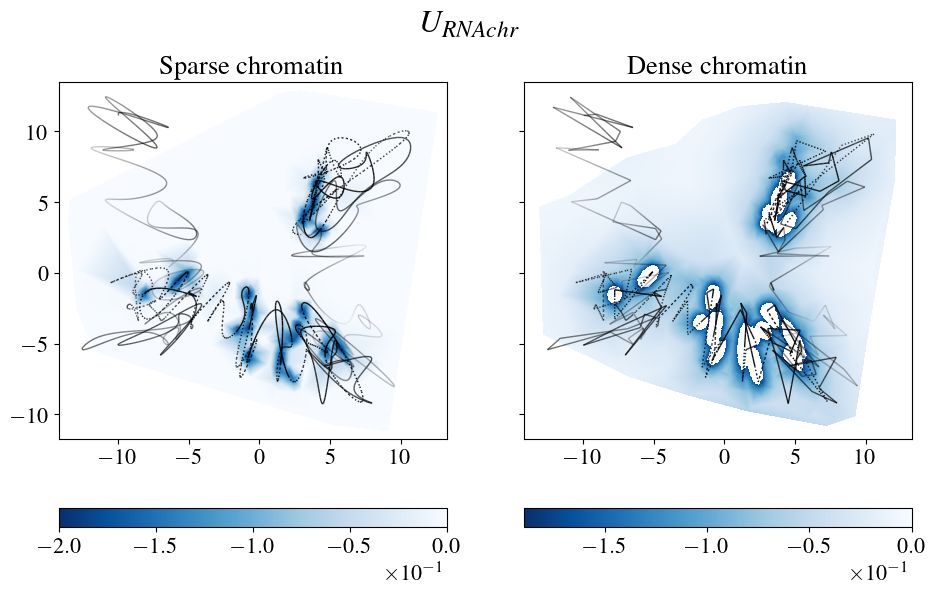

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True)

cs = []
cs.append(axes[0].tricontourf(triang,
                    specific_RNAchr[mask_z],
                    levels=np.linspace(specific_RNAchr.min()*1.001, 0, 256),
                    cmap="Blues_r"))

cs.append(axes[1].tricontourf(triang_dense,
                    specific_RNAchr_dense[mask_z_dense],
                    levels=np.linspace(specific_RNAchr_dense.min()*1.001, 0, 256),
                    cmap="Blues_r"))

plot_curve_with_opacity(axes[0], bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)
plot_curve_with_opacity(axes[1], bin_r, z_plane=plane, num_segments=10, global_max=0, visibility=1)

for i, ax in enumerate(axes):
    ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
    ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    cbar = fig.colorbar(cs[i], ax=ax, orientation='horizontal', fraction=0.05,
                        ticks=[-2.0e-1, -1.5e-1, -1.0e-1, -0.5e-1, 0.0])
    cbar.formatter.set_powerlimits((0, 0))
axes[0].set_title('Sparse chromatin')
axes[1].set_title('Dense chromatin')
plt.suptitle(r'$U_{RNAchr}$', size='x-large')

fig.savefig(fname=f'{path}/figures/{outd}/RNAchr.png', bbox_inches='tight', dpi=300, format='png')

### Concentration-dependent plots

In [57]:
spvar_f = f'results/{sample}/{sim}/spatial_variables.hdf5'
spvar='phi_r'
name='RNA'
with h5py.File(spvar_f, 'r') as f:
    count = 1
    while np.sum(f[spvar][-count]) == 0.0:
         count = count + 1
    if not sparse:
        phi_r_dense = fp.CellVariable(mesh=mesh_dense, name=r'$phi_R$', value = f[spvar][48]) # f[spvar][-count]
    else:
        phi_r = fp.CellVariable(mesh=mesh, name=r'$phi_R$', value = f[spvar][-count])

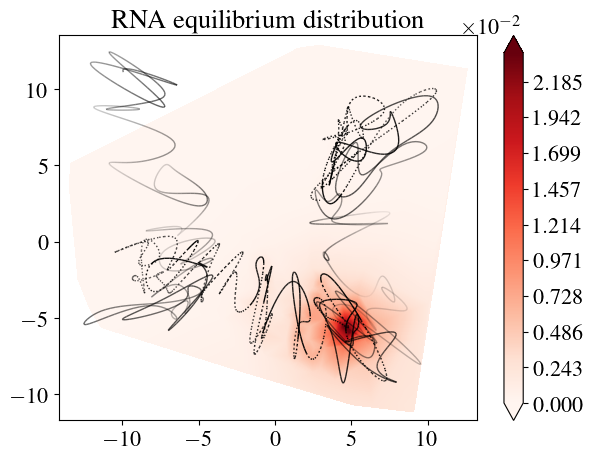

In [58]:
fig, ax = plt.subplots(figsize=(7,5))
plt.title(f'{name} equilibrium distribution')
plot_curve_with_opacity(ax, bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1)
plt.scatter([rna_nucleus_location[0]], [rna_nucleus_location[1]], s=50, c='black')
cs = ax.tricontourf(triang,
                    phi_r[mask_z],
                    levels=np.linspace(phi_r[mask_z].min(), phi_r[mask_z].max(), 256),
                    cmap="Reds",
                    extend="both")
cbar=fig.colorbar(cs, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)

fig.savefig(f'{path}/figures/{sample}/{sim}/{spvar}.png', bbox_inches='tight', dpi=300, format='png')

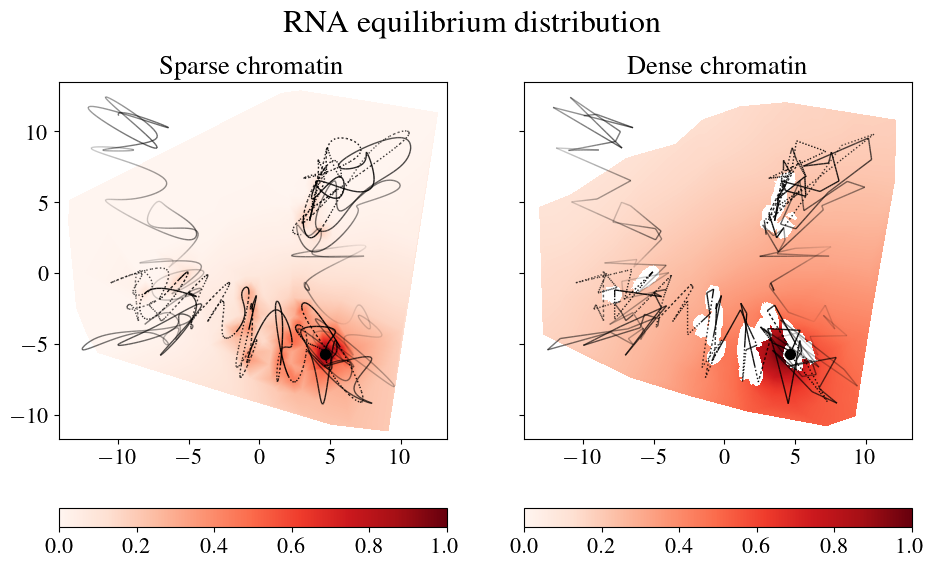

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True)

cs = []
cs.append(axes[0].tricontourf(triang,
                    phi_r[mask_z] / phi_r[mask_z].max(),
                    levels=np.linspace(0, 1, 256),
                    cmap="Reds"))

cs.append(axes[1].tricontourf(triang_dense,
                    phi_r_dense[mask_z_dense] / phi_r_dense[mask_z_dense].max(),
                    levels=np.linspace(0, 1, 256),
                    cmap="Reds"))

plot_curve_with_opacity(axes[0], bin_r_spline, z_plane=plane, num_segments=1, global_max=0, visibility=1.0)
plot_curve_with_opacity(axes[1], bin_r, z_plane=plane, num_segments=10, global_max=0, visibility=1.0)

for i, ax in enumerate(axes):
    ax.scatter([rna_nucleus_location[0]], [rna_nucleus_location[1]], s=50, c='black')
    ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
    ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    cbar=fig.colorbar(cs[i], ax=ax, orientation='horizontal', fraction=0.05)
    cbar.locator = MultipleLocator(0.2)
    cbar.update_ticks()
    
axes[0].set_title('Sparse chromatin')
axes[1].set_title('Dense chromatin')
plt.suptitle(f'{name} equilibrium distribution', size='x-large')

fig.savefig(fname=f'{path}/figures/{outd}/{spvar}.png', bbox_inches='tight', dpi=300, format='png')

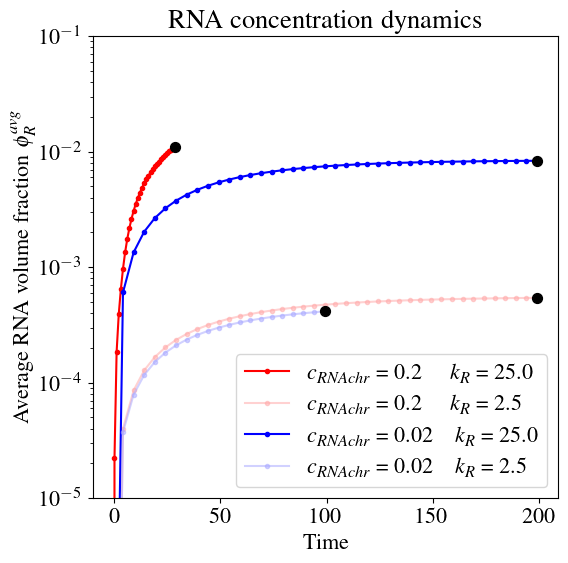

In [165]:
fig, ax = plt.subplots(figsize=(6,6))
colors = ['#ff0000ff', '#ffaaaa88', '#0000ffff', '#aaaaff88']
for i, sim in enumerate(sim_):
    stats_f = f'results/{sample}/{sim}/stats.txt'
    f = pd.read_table(stats_f)
    ax.plot(f['t'], f['phi_r_avg'],
            c=colors[i], marker='.', zorder=-1,
            label=r'$c_{RNAchr}$ = ' + sim_[i].split('_')[8].ljust(8, "~") + 
                  r'$k_{R}$ = ' + sim_[i].split('_')[-1])
    ax.scatter(f['t'][f.index[-1]], f['phi_r_avg'][f.index[-1]], s=50, c='black')

ax.set_ylabel(f'Average {name} ' + r'volume fraction $\phi^{avg}_R$')
ax.set_xlabel('Time')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(loc='lower right')
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e-1)
plt.title(fr'RNA concentration dynamics')
fig.savefig(f'{path}/figures/{outd}/{spvar}_dynamics.svg', bbox_inches='tight', format='svg')

In [59]:
spvar = 'phi_r'
name = 'RNA'
phi_r_list = []
for sim in sim_:
    spvar_f = f'results/{sample}/{sim}/spatial_variables.hdf5'
    with h5py.File(spvar_f, 'r') as f:
        count = 1
        while np.sum(f[spvar][-count]) == 0.0:
             count = count + 1
        if not sparse:
            phi_r_list.append(fp.CellVariable(mesh=mesh_dense, name=r'$phi_R$', value = f[spvar][48])) # f[spvar][-count]
        else:
            phi_r_list.append(fp.CellVariable(mesh=mesh, name=r'$phi_R$', value = f[spvar][-count]))

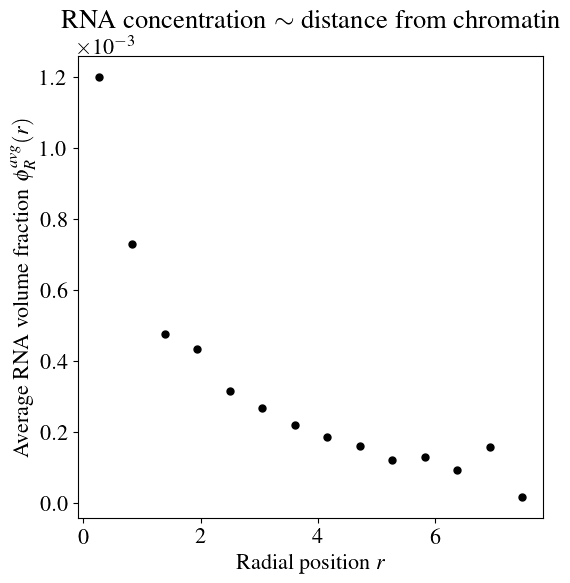

In [61]:
d_max=max(d_chr_sur)
n_points = 15
d_range = np.linspace(0, d_max, n_points)
l=[av_in_domain(mesh, phi_r, (d_range[i]<=d_chr_sur)&(d_chr_sur<d_range[i+1]))
   for i in range(n_points - 1)]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter([d_range[i]+d_max/(n_points - 1)/2 for i in range(n_points - 1)],
            l, s=100, c='black', marker='.')
ax.set_ylabel(f'Average {name} ' + r'volume fraction $\phi^{avg}_R(r)$')
ax.set_xlabel(r'Distance to chromatin')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
plt.title(fr'RNA concentration $\sim$ distance from chromatin')
    
fig.savefig(f'{path}/figures/{sample}/{sim}/{spvar}_av-r.png', bbox_inches='tight', dpi=300, format='png')

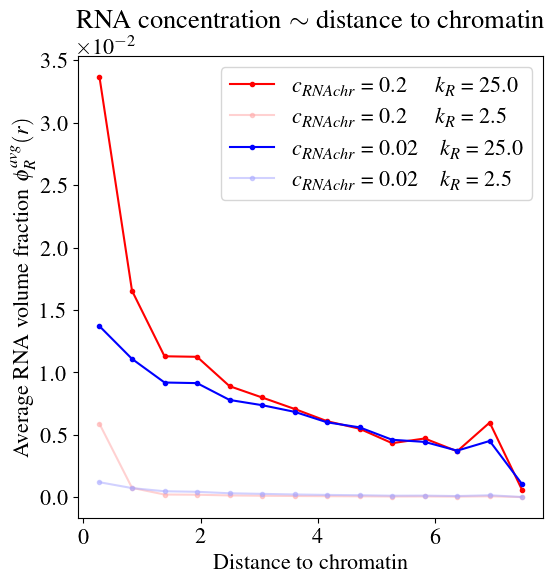

In [151]:
d_max=max(d_chr_sur)
n_points = 15
d_range = np.linspace(0, d_max, n_points)
colors = ['#ff0000ff', '#ffaaaa88', '#0000ffff', '#aaaaff88']

fig, ax = plt.subplots(figsize=(6,6))
for i, phi_r in enumerate(phi_r_list):
    l=[av_in_domain(mesh, phi_r, (d_range[j]<=d_chr_sur)&(d_chr_sur<d_range[j+1]))
       for j in range(n_points - 1)]
    ax.plot([d_range[j]+d_max/(n_points - 1)/2 for j in range(n_points - 1)],
             l, c=colors[i], marker='.', label=r'$c_{RNAchr}$ = ' + sim_[i].split('_')[8].ljust(8, "~") + 
                                               r'$k_{R}$ = ' + sim_[i].split('_')[-1])
ax.set_ylabel(f'Average {name} ' + r'volume fraction $\phi^{avg}_R(r)$')
ax.set_xlabel(r'Distance to chromatin')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(loc='upper right')
# ax.set_yscale('log')
plt.title(fr'RNA concentration $\sim$ distance to chromatin')
    
# fig.savefig(f'{path}/figures/{outd}/{spvar}_av-r.png', bbox_inches='tight', dpi=300, format='png')
fig.savefig(f'{path}/figures/{outd}/{spvar}_av-r.svg', bbox_inches='tight', format='svg')

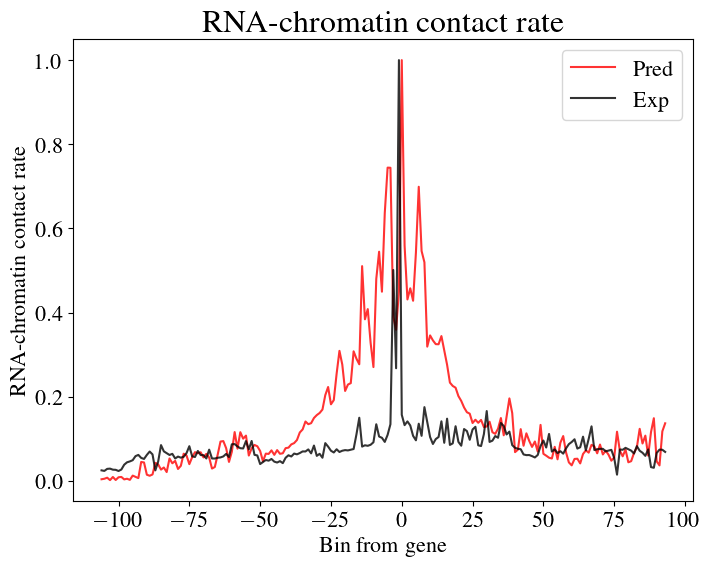

In [173]:
gene_bin = int(input_parameters['lncRNA_gene_bin'])
thres = 0.5
# cmap = plt.get_cmap('Reds_r')
# color_vals = np.linspace(0.0,0.7,len(rnachrom_thress))

fig, ax = plt.subplots(figsize=(8,6))
plt.title(f'{name}-chromatin contact rate', size='x-large')
with h5py.File(dist_f, 'r') as f:
    l=[av_in_domain(mesh, phi_r_list[2], (f['d_bin'][bin_, :]<=thres+0.5)) for bin_ in range(f['d_bin'].shape[0])]
    ax.plot(np.arange(200) - gene_bin,
            l/max(l),
            label='Pred',
            alpha=0.8, color = (1, 0, 0))

ax.plot(np.arange(200) - gene_bin,
        rep1['Score']/max(rep1['Score']),
        label='Exp',
        alpha=0.8, color = 'black')
            
ax.set_xlabel('Bin from gene')
ax.set_ylabel(f'{name}-chromatin contact rate')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
ax.legend(loc='upper right')

# plt.savefig(f'{path}/figures/{sample}/{sim}/{name}Chrom-bin.png', bbox_inches='tight', dpi=300, format="png")

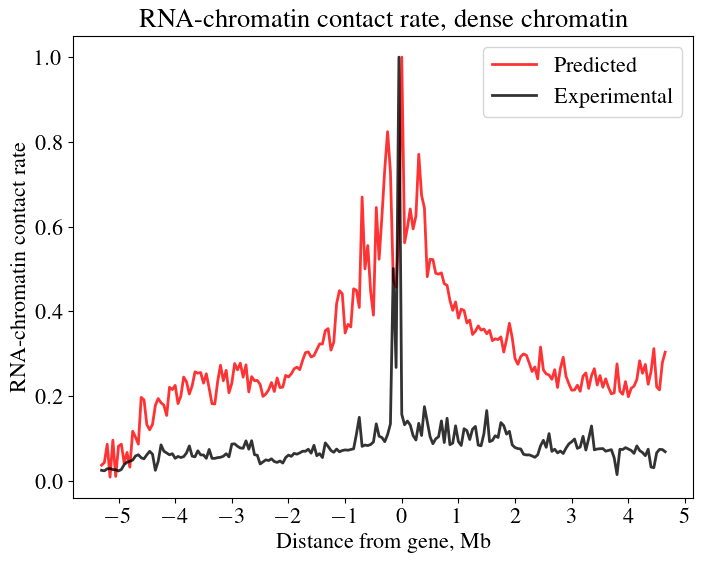

In [248]:
gene_bin = int(input_parameters['lncRNA_gene_bin'])
thres = 0.5
# cmap = plt.get_cmap('Reds_r')
# color_vals = np.linspace(0.0,0.7,len(rnachrom_thress))

fig, ax = plt.subplots(figsize=(8,6))
plt.title(f'{name}-chromatin contact rate, dense chromatin')
with h5py.File(dist_f_dense, 'r') as f:
    l_dense=[av_in_domain(mesh_dense, phi_r_dense, (f['d_bin'][bin_, :]<=thres+0.5)) for bin_ in range(f['d_bin'].shape[0])]
    ax.plot((np.arange(200) - gene_bin) * 0.05,
            l_dense/max(l_dense),
            label='Predicted',
            alpha=0.8, lw=2, color = (1, 0, 0))

ax.plot((np.arange(200) - gene_bin) * 0.05,
        rep1['Score']/max(rep1['Score']),
        label='Experimental',
        alpha=0.8, lw=2, color = 'black')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('Distance from gene, Mb')
ax.set_ylabel(f'{name}-chromatin contact rate')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
ax.legend(loc='upper right')

fig.savefig(f'{path}/figures/{outd}/{name}Chrom-bin_dense.png', bbox_inches='tight', dpi=300, format="png")

# plt.savefig(f'{path}/figures/{sample}/{sim}/{name}Chrom-bin.png', bbox_inches='tight', dpi=300, format="png")

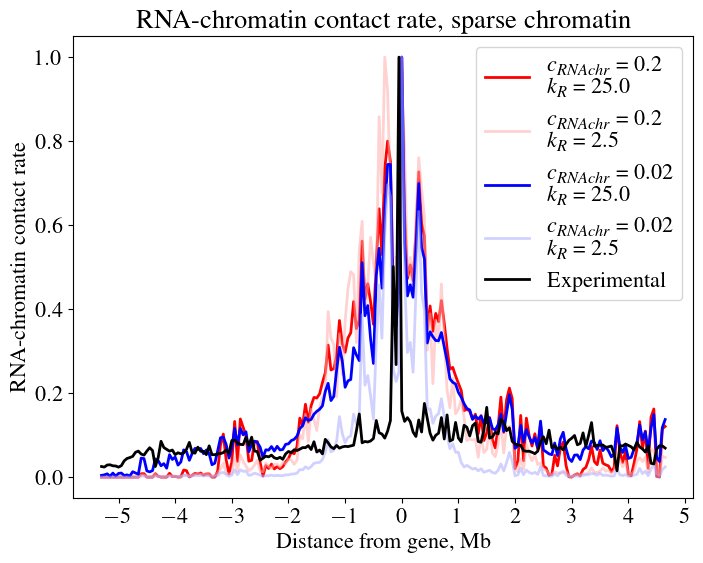

In [217]:
gene_bin = int(input_parameters['lncRNA_gene_bin'])
thres = 0.5
colors = ['#ff0000ff', '#ffaaaa88', '#0000ffff', '#aaaaff88']
# cmap = plt.get_cmap('Reds_r')
# color_vals = np.linspace(0.0,0.7,len(rnachrom_thress))

fig, ax = plt.subplots(figsize=(8,6))
plt.title(f'{name}-chromatin contact rate, sparse chromatin')
for i, phi_r in enumerate(phi_r_list):
    with h5py.File(dist_f, 'r') as f:
        l=[av_in_domain(mesh, phi_r, (f['d_bin'][bin_, :]<=thres+0.5)) for bin_ in range(f['d_bin'].shape[0])]
        ax.plot((np.arange(200) - gene_bin) * 0.05, l/max(l),
                lw=2, color=colors[i],
                label=r'$c_{RNAchr}$ = ' + sim_[i].split('_')[8] + 
                      "\n" + r'$k_{R}$ = ' + sim_[i].split('_')[-1])

ax.plot((np.arange(200) - gene_bin) * 0.05,
        rep1['Score']/max(rep1['Score']),
        lw=2, color = 'black',
        label='Experimental')
            
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('Distance from gene, Mb')
ax.set_ylabel(f'{name}-chromatin contact rate')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
ax.legend(loc='upper right')

fig.savefig(f'{path}/figures/{outd}/{name}Chrom-bin.png', bbox_inches='tight', dpi=300, format="png")
# fig.savefig(f'{path}/figures/{outd}/{name}Chrom-bin.svg', bbox_inches='tight', format='svg')

In [79]:
f__1 = '/home/artem.kays/data/one-to-all_hs/experiment_one_to_all_id_99_method_CHART_organism_Homo_sapiens_tissue_MCF_7_rna_MALAT1/contacts_hg19.normalized_50000.bgr'
rep1 = pd.read_table(f__1, names=['Chromosome', 'Start', 'End', 'Score'], header=None).query('`Chromosome` == "chr11" & `Start`>=6e7 & `End`<=7e7')

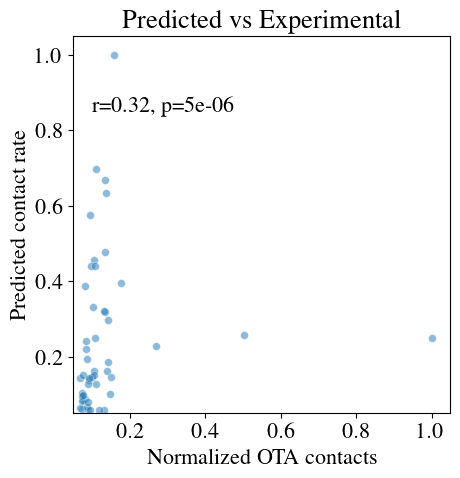

In [245]:
def annotate(data, **kws):
    r, p = pearsonr(data['exp'], data['pred'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)


df = pd.concat([(rep1['Score']/max(rep1['Score'])).reset_index(drop=1), pd.Series(l/max(l))], axis=1)\
        .set_axis(['exp', 'pred'], axis=1)

g = sns.scatterplot(x='exp', y='pred', data=df, s=32, alpha=0.5)
annotate(df)
g.set_xlabel(f'Normalized OTA contacts')
g.set_ylabel(f'Predicted contact rate')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.title(fr'Predicted vs Experimental')
g.xaxis.set_major_locator(MultipleLocator(0.2))
g.yaxis.set_major_locator(MultipleLocator(0.2))
g.set_aspect('equal', adjustable='box')
#ax.set_xscale('log')
#ax.set_yscale('log')

g.set_xlim(0.05, 1.05)
g.set_ylim(0.05, 1.05)

g.figure.savefig(f'{path}/figures/{outd}/pred~exp.png', bbox_inches='tight', dpi=300)
# g.figure.savefig(f'{path}/figures/{sample}/{sim}/pred~exp.png', bbox_inches='tight', dpi=300)

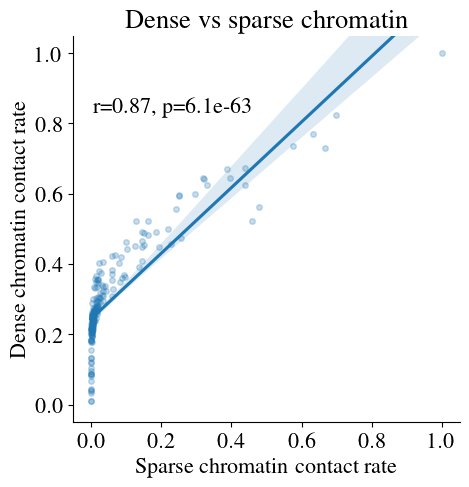

In [246]:
def annotate(data, **kws):
    r, p = pearsonr(data['exp'], data['pred'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)


df = pd.concat([pd.Series(l/max(l)), pd.Series(l_dense/max(l_dense))], axis=1)\
        .set_axis(['exp', 'pred'], axis=1)

g = sns.lmplot(x='exp', y='pred', data=df, scatter_kws={"s": 16, "alpha": 0.25})
g.map_dataframe(annotate)
g.ax.set_xlabel(f'Sparse chromatin contact rate')
g.ax.set_ylabel(f'Dense chromatin contact rate')
g.tight_layout(rect=[0, 0, 1, 1])
plt.title('Dense vs sparse chromatin')
g.ax.xaxis.set_major_locator(MultipleLocator(0.2))
g.ax.yaxis.set_major_locator(MultipleLocator(0.2))
g.ax.set_aspect('equal', adjustable='box')
#ax.set_xscale('log')
#ax.set_yscale('log')

g.ax.set_xlim(-0.05, 1.05)
g.ax.set_ylim(-0.05, 1.05)

g.figure.savefig(f'{path}/figures/{outd}/dense~sparse.png', bbox_inches='tight', dpi=300)

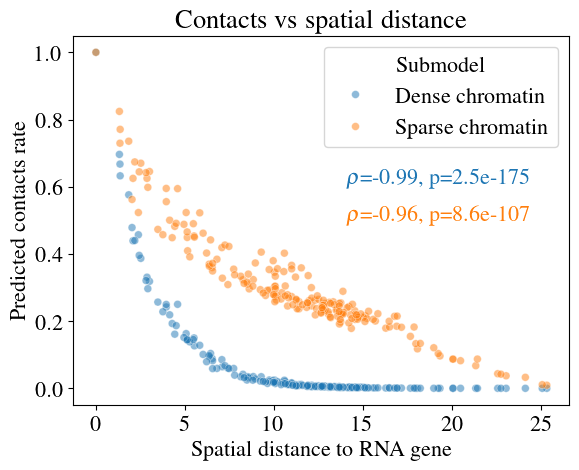

In [287]:
def annotate(data, x, y, c):
    r, p = spearmanr(data['exp'], data['pred'])
    ax = plt.gca()
    ax.text(x, y, r'$\rho$={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, c=c)


df_1 = pd.concat([pd.Series(norm(bin_r-rna_nucleus_location, axis=1)), pd.Series(l/max(l))], axis=1)\
        .set_axis(['exp', 'pred'], axis=1)
df_1['Submodel'] = 'Dense chromatin'
df_2 = pd.concat([pd.Series(norm(bin_r-rna_nucleus_location, axis=1)), pd.Series(l_dense/max(l_dense))], axis=1)\
        .set_axis(['exp', 'pred'], axis=1)
df_2['Submodel'] = 'Sparse chromatin'
df = pd.concat([df_1, df_2])

g = sns.scatterplot(x='exp', y='pred', hue='Submodel', data=df, s=32, alpha=0.5)
annotate(df_1, .55, .6, c=sns.color_palette()[0])
annotate(df_2, .55, .5, c=sns.color_palette()[1])
g.set_xlabel('Spatial distance to RNA gene')
g.set_ylabel('Predicted contacts rate')
plt.title('Contacts vs spatial distance')

g.figure.savefig(f'{path}/figures/{outd}/contacts~dist.png', bbox_inches='tight', dpi=300)

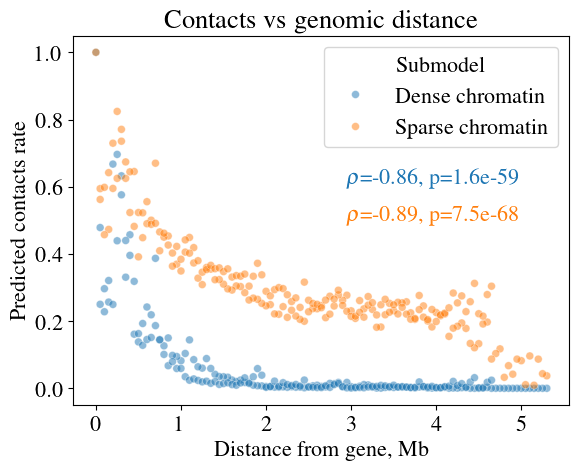

In [286]:
df_1 = pd.concat([abs(pd.Series(np.arange(200) - gene_bin)) * 0.05, pd.Series(l/max(l))], axis=1)\
        .set_axis(['exp', 'pred'], axis=1)
df_1['Submodel'] = 'Dense chromatin'
df_2 = pd.concat([abs(pd.Series(np.arange(200) - gene_bin)) * 0.05, pd.Series(l_dense/max(l_dense))], axis=1)\
        .set_axis(['exp', 'pred'], axis=1)
df_2['Submodel'] = 'Sparse chromatin'
df = pd.concat([df_1, df_2])

g = sns.scatterplot(x='exp', y='pred', hue='Submodel', data=df, s=32, alpha=0.5)
annotate(df_1, .55, .6, c=sns.color_palette()[0])
annotate(df_2, .55, .5, c=sns.color_palette()[1])
g.set_xlabel('Distance from gene, Mb')
g.set_ylabel('Predicted contacts rate')
plt.title('Contacts vs genomic distance')

g.figure.savefig(f'{path}/figures/{outd}/contacts~bin.png', bbox_inches='tight', dpi=300)